In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import argparse
import time
import itertools
from copy import deepcopy
import tensorflow as tf

from tuner import HyperparameterTuner
from tuner import MyTask

use_tpu = False
use_gpu = True

if use_tpu:
    from tensorflow.contrib import tpu
    from tensorflow.contrib.cluster_resolver import TPUClusterResolver

if use_gpu:
    import os
    
%load_ext autoreload
%autoreload 2

In [2]:
if use_gpu:
    os.environ['CUDA_VISIBLE_DEVICES'] = '1'
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True

In [3]:
if use_tpu:
    tpu_cluster = TPUClusterResolver(tpu=[tpu_name]).get_master()
    sess = tf.Session(tpu_cluster)
    sess.run(tpu.initialize_system())
elif use_gpu:
    sess = tf.Session(config=config)
else:
    sess = tf.Session()

In [4]:
# uncomment if required to use default network
# from network import Network

class Network(object):
    def __init__(self):
        self.layers = None
        self.create_layers()

    def create_layers(self):
        self.layers = []
        self.layers.append(tf.layers.Dense(units=256, activation=tf.nn.relu))
        self.layers.append(tf.layers.Dense(units=256, activation=tf.nn.relu))
        self.layers.append(tf.layers.Dense(units=10))

    def forward(self, x, apply_dropout, keep_prob_input=1.0, keep_prob_hidden=1.0):
        layer_output = []
        input_shape = np.prod(x.shape.as_list()[1:])
        x = tf.reshape(x, [-1, input_shape])
        if (apply_dropout):
            x = tf.nn.dropout(x, keep_prob_input)
        y = x
        for i in range(len(self.layers) - 1):
            y = self.layers[i](y)
            if (apply_dropout):
                y = tf.nn.dropout(y, keep_prob_hidden)
            layer_output.append(y)
        y = self.layers[-1](y)
        layer_output.append(y)
        return y, layer_output

    def get_layer_variables(self):
        l = []
        for i in range(len(self.layers)):
            l.extend(self.layers[i].variables)
        return l
    def name(self):
        return 'fc256_fc256_fc10'

In [5]:
network = Network()

In [6]:
task_home = ''
if use_tpu:
    task_home = 'gs://continual_learning/permMNIST_EWC/'
else:
    task_home = './'
checkpoint_path = task_home + '80_20_logs_append_norm/' + network.name() + '/checkpoints/'
summaries_path = task_home + '80_20_logs_append_norm/'+ network.name() + '/summaries/'
data_path = task_home + 'MNIST_data/'
split_path = './split.txt' 
if use_tpu:
    tpu_name = 'gectpu'
    
BATCH_SIZE = 128

In [7]:
label_smooth_param = 0

def read_split(split_path):
    split = []
    try:
        f = open(split_path)
        while (True):
            line = f.readline()
            if (line == ""):
                break
            split.append([float(i) for i in line.split()])
    except IOError:
        print("split path file not found")
        exit(-1)
    return split

from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets
    
def split_mnist(mnist, dataset_split, seed):
    np.random.seed(seed)
    task_list = []
    train_labels = np.argmax(mnist.train.labels, axis=1)
    validation_labels = np.argmax(mnist.validation.labels, axis=1)
    test_labels = np.argmax(mnist.test.labels, axis=1)
    for i in range(len(dataset_split)):
        cur_train_indices = [False] * mnist.train.images.shape[0]
        cur_validation_indices = [False] * mnist.validation.images.shape[0]
        cur_test_indices = [False] * mnist.test.images.shape[0]
        for j in range(len(dataset_split[i])):
            cur_train_indices = np.logical_or(cur_train_indices, (train_labels == dataset_split[i][j]))
            cur_validation_indices = np.logical_or(cur_validation_indices, (validation_labels == dataset_split[i][j]))
            cur_test_indices = np.logical_or(cur_test_indices, (test_labels == dataset_split[i][j]))

        task = deepcopy(mnist)
        task.train._images = task.train._images[cur_train_indices]
        task.train._labels = task.train._labels[cur_train_indices]
        task.validation._images = task.validation._images[cur_validation_indices]
        task.validation._labels = task.validation._labels[cur_validation_indices]
        task.test._images = task.test._images[cur_test_indices]
        task.test._labels = task.test._labels[cur_test_indices]
        task = MyTask(task)
        task_list.append(task)

    return task_list

def smooth_labels(dataset):
    train_labels = dataset.train.labels
    train_labels_argmax = np.argmax(train_labels, axis=1)
    train_labels = train_labels + label_smooth_param / (train_labels.shape[1] - 1)
    train_labels[range(train_labels.shape[0]), train_labels_argmax] = 1 - label_smooth_param
    dataset.train._labels = train_labels
    
        

def read_datasets():
    split = read_split(split_path)
    
    mnist = read_data_sets(data_path, one_hot=True)
    if (label_smooth_param != 0):
        smooth_labels(mnist)
    seed = 1
    task_list = split_mnist(mnist, split, seed)
    return split, task_list


    

In [8]:
input_shape = (28 * 28, )
output_shape = (10, )

In [9]:
tuner = HyperparameterTuner(sess=sess, network=network, 
                            input_shape=input_shape, output_shape=output_shape,
                            checkpoint_path=checkpoint_path, summaries_path=summaries_path, 
                            read_datasets=read_datasets, load_best_hparams=False)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ./MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [10]:
tuner.save_penultimate_output = True
tuner.per_example_append = 2

In [11]:
# task 0
t = 0
seed = 0
np.random.seed(0)
learning_rates = [10 ** (-4 + 2 / 9 * 3)]
fisher_multipliers = [0.0]
dropout_input_probs = [1.0]
dropout_hidden_probs = [0.8]
prod = list(itertools.product(fisher_multipliers, dropout_input_probs, dropout_hidden_probs, learning_rates))
hparams = []
for hparams_tuple in prod:
    cur_dict = {}
    cur_dict['fisher_multiplier'] = hparams_tuple[0]
    cur_dict['dropout_input_prob'] = hparams_tuple[2]
    cur_dict['dropout_hidden_prob'] = hparams_tuple[2]
    cur_dict['learning_rate'] = hparams_tuple[3]
    hparams.append(cur_dict)
tuner.hparams_list[t] = hparams

In [12]:
best_avg, best_hparams = tuner.tune_on_task(t, BATCH_SIZE, save_weights=False)

Training with dropout_hidden_prob=0.8,dropout_input_prob=0.8,fisher_multiplier=0.0,learning_rate=0.00046415888336127773,task=0
epochs: 11.337209, final train loss: 0.023273, validation accuracies: [0.98763293]
best epochs: 9.302326, best_avg: 0.988375, validation accuracies: [0.98837495]
Training with dropout_hidden_prob=0.8,dropout_input_prob=0.8,fisher_multiplier=0.0,learning_rate=0.00046415888336127773,task=0
epochs: 9.302326, final train loss: 0.051549, validation accuracies: [0.98763293]
best epochs: 8.720930, best_avg: 0.988870, validation accuracies: [0.98886967]
saving model dropout_hidden_prob=0.8,dropout_input_prob=0.8,fisher_multiplier=0.0,learning_rate=0.00046415888336127773,task=0 at time step 3200
calculating penultimate output...
time taken: %f 2.0686254501342773
saving penultimate output...


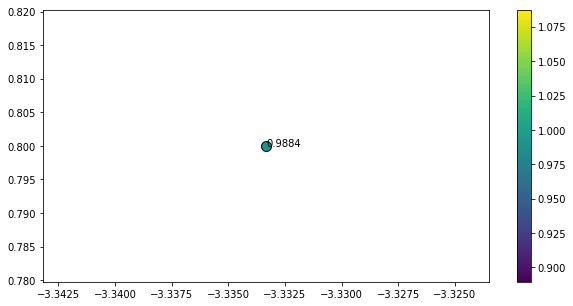

In [13]:
import math
plt.rcParams['figure.figsize'] = [10, 5]
lr_scatter = ([math.log10(h['learning_rate']) for h in hparams])
dropout_scatter = [h['dropout_hidden_prob'] for h in hparams]
colors = []
for i in range(len(hparams)):
    cur_hparam_tuple = tuple([v for k, v in sorted(hparams[i].items())])
    colors.append(tuner.results_list[t][cur_hparam_tuple]['best_avg'])
    
marker_size = 100
fig, ax = plt.subplots()
plt.scatter(lr_scatter, dropout_scatter, marker_size, c=colors, edgecolors='black')
plt.colorbar()
for i in range(len(lr_scatter)):
    ax.annotate(str('%0.4f' % (colors[i], )), (lr_scatter[i], dropout_scatter[i]))
plt.show()

In [54]:
# best_avg = 0.0
# best_hparams = None
# for k, v in tuner.results_list[t].items():
#     cur_best_avg = v['best_avg']
#     if (best_avg < cur_best_avg):
#         best_avg = cur_best_avg
# best_avg = 0.9868909120559692
# best_hparams = {'dropout_hidden_prob': 0.9, 'dropout_input_prob': 1.0, 'fisher_multiplier': 0.0, 'learning_rate': 10 ** (-4 + 16/19)}
# prev_best_hparams_tuple = tuple([v for k, v in sorted(tuner.best_hparams[t][0].items())])
# prev_best_avg = tuner.results_list[t][prev_best_hparams_tuple]['best_avg']
# if (best_avg > prev_best_avg):
#     tuner.best_hparams[t] = (best_hparams, tuner.file_name(t, best_hparams))
# print(tuner.best_hparams[t])
# best_hparams_tuple = tuple([v for k, v in sorted(best_hparams.items())])
# cur_result = tuner.train(t, tuner.best_hparams[t][0], BATCH_SIZE, 
#                             num_updates=tuner.results_list[t][best_hparams_tuple]['best_avg_updates'])
# tuner.classifier.update_fisher_full_batch(tuner.sess, tuner.task_list[t].train)

# tuner.classifier.save_weights(tuner.results_list[t][best_hparams_tuple]['best_avg_updates'], 
#                                 tuner.sess, tuner.file_name(t, best_hparams))

# x = np.arange(0, len(cur_res['loss']), tuner.eval_frequency)
# best_hparams_tuple = tuple([v for k, v in sorted(best_hparams.items())])
# cur_res = tuner.results_list[t][best_hparams_tuple]
# # plt.plot(cur_res['loss_with_penalty'], color='g')
# plt.plot(cur_res['loss'], color='m')
# plt.plot(x, cur_res['val_loss'][-1], color='b')
# plt.show()
# plt.plot(cur_res['val_acc'][0], color='b')
# plt.show()

# v = sess.run(tuner.classifier.network.layers[1].variables)
# print(np.mean(v[0][:, 1]), np.mean(v[0][:, 9]))
# for i in range(output_shape[0]):
#     print(np.mean(v[0][:, i]))

-0.17803755
-0.10262482
-0.092969276
-0.12613258
-0.12512842
-0.07063656
-0.12184537
-0.07729137
-0.045544185
0.01739812


In [15]:
print(best_avg, best_hparams)
VALIDATION_BATCH_SIZE = 32
print(tuner.validation_accuracy(t, VALIDATION_BATCH_SIZE))

0.9883749485015869 {'fisher_multiplier': 0.0, 'dropout_input_prob': 0.8, 'dropout_hidden_prob': 0.8, 'learning_rate': 0.00046415888336127773}
INFO:tensorflow:Restoring parameters from ./80_20_logs_append_norm/fc256_fc256_fc10/checkpoints/dropout_hidden_prob=0.8,dropout_input_prob=0.8,fisher_multiplier=0.0,learning_rate=0.00046415888336127773,task=0.ckpt-3200
[0.9885912698412699]


In [54]:
# task 1
t = 1
seed = 0
np.random.seed(0)
learning_rates = list(np.logspace(-5, -2, 4))
fisher_multipliers = [0.0]
dropout_input_probs = [1.0]
dropout_hidden_probs = [0.8]
prod = list(itertools.product(fisher_multipliers, dropout_input_probs, dropout_hidden_probs, learning_rates))
hparams = []
for hparams_tuple in prod:
    cur_dict = {}
    cur_dict['fisher_multiplier'] = hparams_tuple[0]
    cur_dict['dropout_input_prob'] = hparams_tuple[2]
    cur_dict['dropout_hidden_prob'] = hparams_tuple[2]
    cur_dict['learning_rate'] = hparams_tuple[3]
    hparams.append(cur_dict)
tuner.hparams_list[t] = hparams

In [23]:
# tuner.save_penultimate_output = True
# tuner.per_example_append = 2

In [55]:
best_avg, best_hparams = tuner.tune_on_task(t, BATCH_SIZE, save_weights=False)

INFO:tensorflow:Restoring parameters from ./80_20_logs_append_norm/fc256_fc256_fc10/checkpoints/dropout_hidden_prob=0.8,dropout_input_prob=0.8,fisher_multiplier=0.0,learning_rate=0.00046415888336127773,task=0.ckpt-3200
Training with dropout_hidden_prob=0.8,dropout_input_prob=0.8,fisher_multiplier=0.0,learning_rate=1e-05,task=1
Restoring paramters from dropout_hidden_prob=0.8,dropout_input_prob=0.8,fisher_multiplier=0.0,learning_rate=0.00046415888336127773,task=0
INFO:tensorflow:Restoring parameters from ./80_20_logs_append_norm/fc256_fc256_fc10/checkpoints/dropout_hidden_prob=0.8,dropout_input_prob=0.8,fisher_multiplier=0.0,learning_rate=0.00046415888336127773,task=0.ckpt-3200
epochs: 155.555556, final train loss: 0.095849, validation accuracies: [0.9816968  0.98268396]
best epochs: 150.000000, best_avg: 0.982246, validation accuracies: [0.98219144 0.98268396]
Training with dropout_hidden_prob=0.8,dropout_input_prob=0.8,fisher_multiplier=0.0,learning_rate=0.0001,task=1
Restoring paramt

In [26]:
import math
lr_scatter = ([math.log10(h['learning_rate']) for h in hparams])
fm_scatter = [math.log10(h['fisher_multiplier']) for h in hparams]
colors = []
for i in range(len(hparams)):
    cur_hparam_tuple = tuple([v for k, v in sorted(hparams[i].items())])
    colors.append(tuner.results_list[t][cur_hparam_tuple]['best_avg'])
    
marker_size = 100
fig, ax = plt.subplots()
plt.scatter(lr_scatter, fm_scatter, marker_size, c=colors, edgecolors='black')
plt.colorbar()
for i in range(len(lr_scatter)):
    ax.annotate(str('%0.4f' % (colors[i], )), (lr_scatter[i], fm_scatter[i]))
plt.show()

ValueError: math domain error

In [47]:
print(best_avg, best_hparams)
VALIDATION_BATCH_SIZE = 32
t = 1
print(tuner.validation_accuracy(t, VALIDATION_BATCH_SIZE))

0.9669828951358795 {'fisher_multiplier': 0.0, 'dropout_input_prob': 0.8, 'dropout_hidden_prob': 0.8, 'learning_rate': 1e-05}
INFO:tensorflow:Restoring parameters from ./80_20_logs_append_norm/fc256_fc256_fc10/checkpoints/dropout_hidden_prob=0.8,dropout_input_prob=0.8,fisher_multiplier=0.0,learning_rate=1e-05,task=1.ckpt-9100
[0.9801587301587301, 0.9732142857142857]


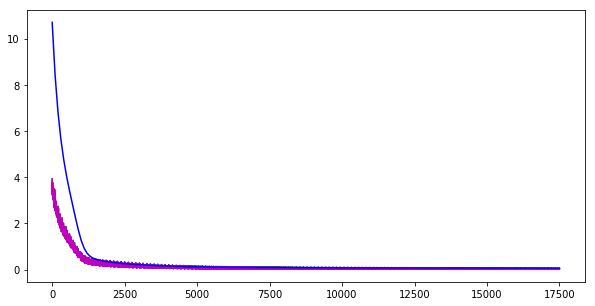

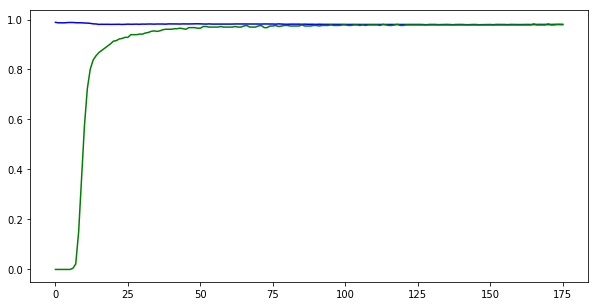

In [28]:
best_hparams_tuple = tuple([v for k, v in sorted(best_hparams.items())])
cur_res = tuner.results_list[t][best_hparams_tuple]
x = np.arange(0, len(cur_res['loss']), tuner.eval_frequency)
plt.plot(cur_res['loss_with_penalty'], color='g')
plt.plot(cur_res['loss'], color='m')
plt.plot(x, cur_res['val_loss'][-1], color='b')
# plt.plot(x, cur_res['val_loss'][0], color='g')
plt.show()
plt.plot(cur_res['val_acc'][0], color='b')
plt.plot(cur_res['val_acc'][1], color='g')
plt.show()


In [43]:
best_hparams_1_backup = tuner.best_hparams[t]
tuner.best_hparams[t] = (best_hparams, tuner.file_name(t, best_hparams))

In [44]:
# task 2
t = 2
seed = 0
np.random.seed(0)
learning_rates = list(np.logspace(-5, -2, 4))
fisher_multipliers = [0.0]
dropout_input_probs = [1.0]
dropout_hidden_probs = [0.8]
prod = list(itertools.product(fisher_multipliers, dropout_input_probs, dropout_hidden_probs, learning_rates))
hparams = []
for hparams_tuple in prod:
    cur_dict = {}
    cur_dict['fisher_multiplier'] = hparams_tuple[0]
    cur_dict['dropout_input_prob'] = hparams_tuple[2]
    cur_dict['dropout_hidden_prob'] = hparams_tuple[2]
    cur_dict['learning_rate'] = hparams_tuple[3]
    hparams.append(cur_dict)
tuner.hparams_list[t] = hparams

In [44]:
# tuner.save_penultimate_output = True
# tuner.per_example_append = 2

In [45]:
best_avg, best_hparams = tuner.tune_on_task(t, BATCH_SIZE, save_weights=False)

INFO:tensorflow:Restoring parameters from ./80_20_logs_append_norm/fc256_fc256_fc10/checkpoints/dropout_hidden_prob=0.8,dropout_input_prob=0.8,fisher_multiplier=0.0,learning_rate=1e-05,task=1.ckpt-9100
Training with dropout_hidden_prob=0.8,dropout_input_prob=0.8,fisher_multiplier=0.0,learning_rate=1e-05,task=2
Restoring paramters from dropout_hidden_prob=0.8,dropout_input_prob=0.8,fisher_multiplier=0.0,learning_rate=1e-05,task=1
INFO:tensorflow:Restoring parameters from ./80_20_logs_append_norm/fc256_fc256_fc10/checkpoints/dropout_hidden_prob=0.8,dropout_input_prob=0.8,fisher_multiplier=0.0,learning_rate=1e-05,task=1.ckpt-9100
epochs: 98.425197, final train loss: 0.095172, validation accuracies: [0.96908236 0.93722945 0.969697  ]
best epochs: 60.629921, best_avg: 0.966983, validation accuracies: [0.97081375 0.94372296 0.959596  ]
Training with dropout_hidden_prob=0.8,dropout_input_prob=0.8,fisher_multiplier=0.0,learning_rate=0.0001,task=2
Restoring paramters from dropout_hidden_prob=0.

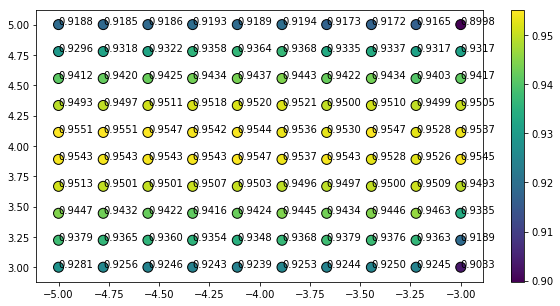

In [43]:
import math
plt.rcParams['figure.figsize'] = [10, 5]
lr_scatter = ([math.log10(h['learning_rate']) for h in hparams])
fm_scatter = [math.log10(h['fisher_multiplier']) for h in hparams]
colors = []
for i in range(len(hparams)):
    cur_hparam_tuple = tuple([v for k, v in sorted(hparams[i].items())])
    colors.append(tuner.results_list[t][cur_hparam_tuple]['best_avg'])
    
marker_size = 100
fig, ax = plt.subplots()
plt.scatter(lr_scatter, fm_scatter, marker_size, c=colors, edgecolors='black')
plt.colorbar()
for i in range(len(lr_scatter)):
    ax.annotate(str('%0.4f' % (colors[i], )), (lr_scatter[i], fm_scatter[i]))
plt.show()

In [48]:
t = 2
best_hparams_2_backup = tuner.best_hparams[t]
tuner.best_hparams[t] = (best_hparams, tuner.file_name(t, best_hparams))

In [49]:
print(best_avg, best_hparams)
VALIDATION_BATCH_SIZE = 32
print(tuner.validation_accuracy(t, VALIDATION_BATCH_SIZE))

0.9669828951358795 {'fisher_multiplier': 0.0, 'dropout_input_prob': 0.8, 'dropout_hidden_prob': 0.8, 'learning_rate': 1e-05}
INFO:tensorflow:Restoring parameters from ./80_20_logs_append_norm/fc256_fc256_fc10/checkpoints/dropout_hidden_prob=0.8,dropout_input_prob=0.8,fisher_multiplier=0.0,learning_rate=1e-05,task=2.ckpt-7700
[0.9697420634920635, 0.9441964285714286, 0.9583333333333334]


In [32]:
tuner.save_results_list()
tuner.save_best_hparams()

cur_best_avg: 9.733004e-01, num_updates: 47000
best val_acc: [0.97872865 0.9415584  0.96161616]


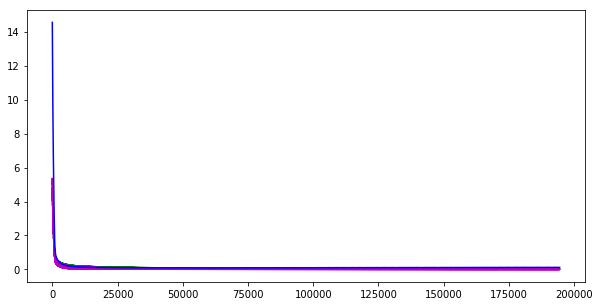

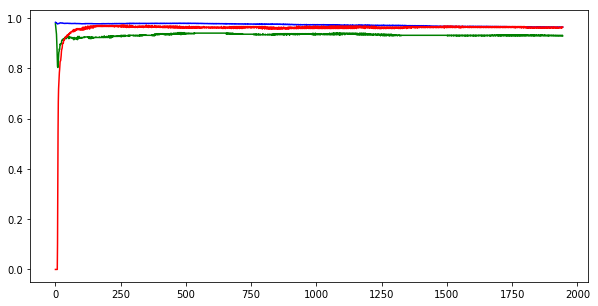

In [33]:
# print("best_avg: %e, best_params: %s" % (best_avg, str(best_params)))
# print("best_params: dropout: %f, fisher_multiplier: %e, lr: %e" % best_params)

# for k, v in tuner.results_list.items():
# best_avg_tuple = tuple([v for k, v in sorted(tuner.best_hparams[t][0].items())])
best_hparams_tuple = tuple([v for k, v in sorted(best_hparams.items())])
cur_res = tuner.results_list[t][best_hparams_tuple]
x = np.arange(0, len(cur_res['loss']), tuner.eval_frequency)
cur_best_avg = cur_res['best_avg']
cur_best_avg_updates = cur_res['best_avg_updates']
# print("dropout: %f, fisher_multiplier: %e, lr: %e" % (k[0], k[1], k[2]))
print("cur_best_avg: %e, num_updates: %d" % (cur_best_avg, cur_best_avg_updates))
print("best val_acc: %s" % (str(np.array(cur_res['val_acc'])[:, cur_best_avg_updates // tuner.eval_frequency])))
plt.plot(cur_res['loss_with_penalty'], color='g')
plt.plot(cur_res['loss'], color='m')
plt.plot(x, cur_res['val_loss'][-1], color='b')
plt.show()
plt.plot(cur_res['val_acc'][0], color='b')
plt.plot(cur_res['val_acc'][1], color='g')
plt.plot(cur_res['val_acc'][2], color='r')

plt.show()

In [34]:
for i in range(t + 1):
    print(tuner.best_hparams[i])

({'fisher_multiplier': 0.0, 'dropout_input_prob': 0.8, 'dropout_hidden_prob': 0.8, 'learning_rate': 0.00046415888336127773}, 'dropout_hidden_prob=0.8,dropout_input_prob=0.8,fisher_multiplier=0.0,learning_rate=0.00046415888336127773,task=0')
({'fisher_multiplier': 100.0, 'dropout_input_prob': 1.0, 'dropout_hidden_prob': 1.0, 'learning_rate': 1e-05}, 'dropout_hidden_prob=1.0,dropout_input_prob=1.0,fisher_multiplier=100.0,learning_rate=1e-05,task=1')
({'fisher_multiplier': 100.0, 'dropout_input_prob': 1.0, 'dropout_hidden_prob': 1.0, 'learning_rate': 1e-05}, 'dropout_hidden_prob=1.0,dropout_input_prob=1.0,fisher_multiplier=100.0,learning_rate=1e-05,task=2')


In [50]:
def get_confusion_matrix(tuner):
    num_labels = 10
    pred = np.array([])
    actual = np.array([])
    for j in range(t + 1):
        val_data = tuner.task_list[j].validation
        feed_dict = tuner.classifier.create_feed_dict(val_data.images, val_data.labels)
        cur_scores, cur_y = tuner.classifier.get_predictions(sess, feed_dict)
        cur_pred = np.argmax(cur_scores, 1)
        cur_actual = np.argmax(cur_y, 1)
        actual = np.concatenate([actual, cur_actual])
        pred = np.concatenate([pred, cur_pred])
    confusion_matrix = np.zeros((num_labels,num_labels), dtype=np.int64)

    for i in range(actual.shape[0]):
        confusion_matrix[int(actual[i]), int(pred[i])] += 1
    return confusion_matrix

def print_confusion_matrix(confusion_matrix):
    print("%3d" % (0, ), end=' ')
    for j in range(confusion_matrix.shape[1]):
        print("%3d" % (j, ), end=' ')
    print("")
    for i in range(confusion_matrix.shape[0]):
        print("%3d" % (i, ), end=' ')
        for j in range(confusion_matrix.shape[1]):
            print("%3d" % (confusion_matrix[i][j], ), end= ' ')
        print("")

In [51]:
# confusion matrix before training
# train on best hyperparameters

# best_params = (1.0, 10 ** (18 / 19 + 4), 5e-6)
# best_num_updates = 3600

# dropout, fisher_multiplier, lr = best_params
# best_num_updates = result[best_params]['best_avg'][1]

# model_name = tuner.file_name(lr, fisher_multiplier, t)
# tuner.classifier.prepare_for_training(sess=tuner.sess, 
#                                     model_name=model_name, 
#                                     model_init_name=model_init_name, 
#                                     fisher_multiplier=fisher_multiplier, 
#                                     learning_rate=lr)

confusion_matrix = get_confusion_matrix(tuner)
print_confusion_matrix(confusion_matrix)


  0   0   1   2   3   4   5   6   7   8   9 
  0 473   0   0   0   0   1   0   0   3   2 
  1   0 551   0   2   1   0   0   2   3   4 
  2   0   4 448   1   3   0   0  11  19   2 
  3   0   0   0 476   0   2   1   5   4   5 
  4   0   0   0   0 530   0   0   1   0   4 
  5   0   0   1   6   0 416   2   0   6   3 
  6   1   1   0   0   5   2 488   0   1   3 
  7   0   0   1   0   1   0   0 539   2   7 
  8   0   2   1   3   2   2   0   0 436  16 
  9   1   2   0   2   3   1   0   8   4 474 


[ 394  949 1319 4681  634 1906  503  392 5389    0]
[ 119   99   31  479 6173  334   14 2712  947 5454]


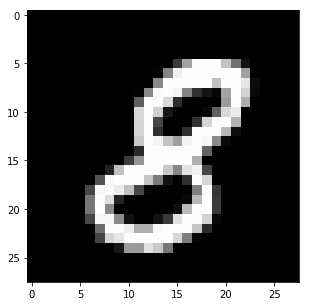

In [52]:
plt.imshow(tuner.appended_task_list[1].train.images[0].reshape(28, 28), cmap='gray')
examples_per_class_1 = np.sum(tuner.appended_task_list[1].train.labels, axis=0).astype(np.int64)
examples_per_class_2 = np.sum(tuner.appended_task_list[2].train.labels, axis=0).astype(np.int64)
print(examples_per_class_1)
print(examples_per_class_2)

In [53]:
# # test accuracy
# for j in range(t + 1):
#     test_data = tuner.task_list[j].test
#     feed_dict = tuner.classifier.create_feed_dict(test_data.images, test_data.labels)
#     accuracy = sess.run([tuner.classifier.loss, tuner.classifier.accuracy], feed_dict=feed_dict)
#     print(accuracy)
TEST_BATCH_SIZE = 32
accuracy = tuner.test(t, TEST_BATCH_SIZE)
print(accuracy)

INFO:tensorflow:Restoring parameters from ./80_20_logs_append_norm/fc256_fc256_fc10/checkpoints/dropout_hidden_prob=0.8,dropout_input_prob=0.8,fisher_multiplier=0.0,learning_rate=1e-05,task=2.ckpt-7700
[0.96675, 0.94375, 0.9536290322580645]


In [49]:
if use_tpu:
    sess.run(tpu.shutdown_system())

sess.close()